In [2]:
import numpy as np
import cv2

import sys 
sys.path.append('../utils')

In [3]:
from image_processing_helper import *
from radiomics_helper import *

c:\Users\rautc\miniforge3\envs\aln_env\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
c:\HII Lab\Breast Cancer\Breast_Cancer_Ultrasound_Project_AIIMS\models\../utils\image_processing_helper.py:4: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


In [4]:
cropped_images_folder = "../data/nodes_data/december_nodes_images/Cropped_Images_Folder"
cropped_clean_images_folder = "../data/nodes_data/december_nodes_images/Cropped_Clean_Images_Folder"

In [10]:
img_path = cropped_images_folder + "/P_101_3.PNG"
img_out_path = cropped_clean_images_folder + "/P_101_2.PNG"

In [11]:
img = read_as_grayscale(img_path)
cross_mask = manual_mask_segmentation(img)

Draw the contour using left mouse button. Press 's' to finish and return the mask.


In [12]:
Image.fromarray(cross_mask).save("crossmark_mask.png")

In [13]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import numpy as np

# Load pre-trained inpainting model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", 
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

def inpaint_ultrasound(image_path, mask_path, prompt="clean medical ultrasound image without artifacts", strength=0.99, guidance_scale=7.5):
    """
    Inpaint ultrasound image to remove crossmarks.
    
    Args:
    - image_path: Path to original ultrasound PNG/JPG.
    - mask_path: Path to mask (white=area to inpaint, black=keep) same size as image.
    - prompt: Describes desired fill (e.g., "homogeneous breast tissue ultrasound").
    - strength: Denoising strength (0.8-1.0 for strong artifacts).
    - guidance_scale: Prompt adherence (5-10).
    
    Returns: Inpainted PIL Image.
    """
    init_image = Image.open(image_path).convert("RGB").resize((512, 512))
    mask_image = Image.open(mask_path).convert("L").resize((512, 512))
    
    result = pipe(
        prompt=prompt,
        image=init_image,
        mask_image=mask_image,
        num_inference_steps=50,
        strength=strength,
        guidance_scale=guidance_scale
    ).images[0]
    
    return result

# Example usage (create mask manually or via OpenCV for crossmarks)
temp = inpaint_ultrasound(img_path, "crossmark_mask.png")


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\rautc\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\rautc\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\rautc\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\rautc\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/49 [00:00<?, ?it/s]

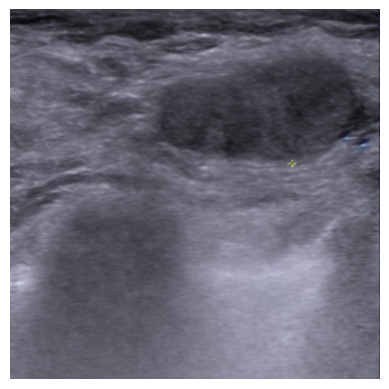

In [14]:
imdisp(temp)

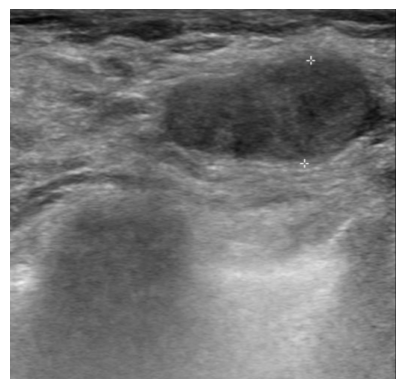

In [17]:
imdisp(img)

In [22]:
mask_img = create_rect_mask(img_path)

Instructions:
  Left drag: draw rectangle over crossmark
  u: undo last rectangle
  c: clear all
  s: save mask and exit
  q or ESC: quit without saving
Mask saved to crossmark_mask_rect.png


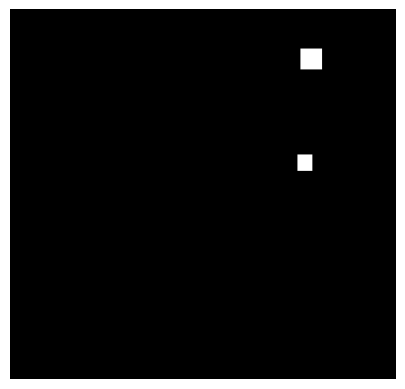

In [23]:
imdisp(mask_img)